In [1]:
# Instala a biblioteca ultralytics para uso do modelo YOLO
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# Importa a biblioteca OpenCV para manipulação de imagens e vídeos
import cv2

# Importa a biblioteca time para medições de tempo e pausas na execução do código
import time

# Importa a biblioteca os para manipulação de arquivos e diretórios
import os

# Ignora avisos desnecessários para evitar poluição na saída do notebook
import warnings

# Importa o Matplotlib para geração de gráficos e visualizações
import matplotlib.pyplot as plt

# Importa o Seaborn para visualizações estatísticas aprimoradas
import seaborn as sns

# Permite exibir Markdown no Jupyter Notebook para formatação de textos
from IPython.display import display, Markdown

# Importa a funcionalidade de upload e download de arquivos no Google Colab
from google.colab import files

In [10]:
# Desativa avisos do MoviePy para evitar mensagens desnecessárias no console
warnings.filterwarnings("ignore", category=UserWarning, module="moviepy")

# Função para processar imagem ou vídeo e aplicar modelo de detecção de postura
def processar_midia(caminho_entrada, modelo, tipo='video', caminho_saida='/content/saida.mp4'):
    # Verifica se o tipo é válido (imagem ou vídeo)
    if tipo not in ['imagem', 'video']:
        raise ValueError("Tipo deve ser 'imagem' ou 'video'.")

    # Inicializa contadores de tempo para cada postura e o background
    tempo_deitado = 0
    tempo_sentado = 0
    tempo_em_pe = 0
    tempo_background = 0
    tempo_total = 0

    # Listas para armazenar informações sobre posturas e transições
    posturas_tempo = []
    transicoes = []

    # Dicionário para armazenar a duração das posturas detectadas
    duracoes_posturas = {0: [], 1: [], 2: [], 3: []}  # 0: Deitado, 1: Sentado, 2: Em Pé, 3: Background

    # Marca o início do tempo de execução do processamento
    inicio_execucao = time.time()

    # Se for uma imagem, processa apenas um único quadro
    if tipo == 'imagem':
        img = cv2.imread(caminho_entrada)  # Lê a imagem
        results = modelo.predict(img, conf=0.1, verbose=False)  # Faz a predição no modelo com confiança mínima de 10%
        annotated_img = results[0].plot()  # Desenha as anotações na imagem
        cv2.imwrite(caminho_saida, annotated_img)  # Salva a imagem processada
        return caminho_saida  # Retorna o caminho do arquivo salvo
    else:  # Processamento de vídeo
        cap = cv2.VideoCapture(caminho_entrada)  # Abre o arquivo de vídeo
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Obtém a largura do vídeo
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Obtém a altura do vídeo
        fps = int(cap.get(cv2.CAP_PROP_FPS))  # Obtém os frames por segundo (FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Obtém o número total de quadros

        # Define o codec de vídeo e cria um objeto para salvar o vídeo processado
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(caminho_saida, fourcc, fps, (width, height))

        # Inicializa variáveis para rastrear transições entre posturas
        postura_anterior = None
        duracao_atual = 0

        # Loop para processar cada quadro do vídeo
        while cap.isOpened():
            ret, frame = cap.read()  # Lê um quadro do vídeo
            if not ret:
                break  # Se não houver mais quadros, encerra o loop

            # Aplica o modelo ao quadro e obtém os resultados
            results = modelo.predict(frame, conf=0.1, verbose=False)
            annotated_frame = results[0].plot()  # Adiciona anotações ao quadro
            out.write(annotated_frame)  # Salva o quadro anotado no vídeo de saída

            frame_classificado = False  # Flag para verificar se o quadro foi classificado
            class_id = 3  # Define o background como padrão

            # Percorre os resultados para identificar a postura detectada
            for result in results:
                for box in result.boxes:
                    class_id = int(box.cls)  # Obtém a classe detectada
                    frame_classificado = True  # Marca o quadro como classificado
                    break  # Interrompe após encontrar a primeira detecção válida

            # Atualiza contadores de tempo para cada postura
            if not frame_classificado:
                tempo_background += 1
            else:
                if class_id == 0:
                    tempo_deitado += 1
                elif class_id == 1:
                    tempo_sentado += 1
                elif class_id == 2:
                    tempo_em_pe += 1

            # Controle de transições e durações das posturas
            if postura_anterior is None:
                postura_anterior = class_id
                duracao_atual = 1
            elif postura_anterior == class_id:
                duracao_atual += 1
            else:
                duracoes_posturas[postura_anterior].append(duracao_atual / fps)  # Converte duração para segundos
                transicoes.append((postura_anterior, class_id))  # Registra a transição
                postura_anterior = class_id
                duracao_atual = 1  # Reinicia a duração

            tempo_total += 1
            posturas_tempo.append(class_id)

        # Libera os objetos de captura e escrita de vídeo
        cap.release()
        out.release()

        # Registra o tempo de execução
        fim_execucao = time.time()
        tempo_execucao = fim_execucao - inicio_execucao

        # Exibir relatório de tempo em formato Markdown
        relatorio_tabela = f"""
# 📊 Relatório de Tempo (em Segundos)

| Categoria      | Tempo (s) | Porcentagem |
|---------------|----------|------------|
| **Deitado**   | {tempo_deitado / fps:.2f}  | {(tempo_deitado / tempo_total) * 100:.2f}% |
| **Sentado**   | {tempo_sentado / fps:.2f}  | {(tempo_sentado / tempo_total) * 100:.2f}% |
| **Em Pé**     | {tempo_em_pe / fps:.2f}    | {(tempo_em_pe / tempo_total) * 100:.2f}% |
| **Background** | {tempo_background / fps:.2f}  | {(tempo_background / tempo_total) * 100:.2f}% |
| **Duração do Vídeo**  | {total_frames / fps:.2f}  | 100% |
| **Tempo de Processamento** | {tempo_execucao:.2f} | - |
"""
        display(Markdown(relatorio_tabela))

        # Criar gráficos para análise dos dados
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Gráfico de pizza para distribuição de tempo por postura
        labels = ['Deitado', 'Sentado', 'Em Pé', 'Background']
        tempos = [tempo_deitado, tempo_sentado, tempo_em_pe, tempo_background]
        colors = ['#FF6384', '#36A2EB', '#FFCE56', '#B0B0B0']
        axes[0, 0].pie(tempos, labels=labels, autopct='%1.1f%%', colors=colors)
        axes[0, 0].set_title('Distribuição de Tempos por Posição')

        # Gráfico KDE para distribuição de durações por postura
        for class_id, label, color in zip([0, 1, 2], ['Deitado', 'Sentado', 'Em Pé'], ['#FF6384', '#36A2EB', '#FFCE56']):
            if duracoes_posturas[class_id]:
                sns.kdeplot(duracoes_posturas[class_id], ax=axes[0, 1], fill=True, color=color, label=label, bw_adjust=1.5, clip=(0, None))

        axes[0, 1].set_title('Distribuição das Durações por Posição')
        axes[0, 1].set_xlabel('Duração (s)')
        axes[0, 1].set_ylabel('Densidade')
        axes[0, 1].legend()
        sns.despine(ax=axes[0, 1])

        # Histograma de mudanças de postura
        transicoes_numericas = [f'{t[0]}→{t[1]}' for t in transicoes]
        sns.histplot(transicoes_numericas, ax=axes[1, 0])
        axes[1, 0].set_title('Frequência das Mudanças Entre Posturas')
        axes[1, 0].set_xlabel('Transição')
        sns.despine(ax=axes[1, 0])

        fig.delaxes(axes[1, 1])  # Remove espaço vazio
        plt.tight_layout()
        plt.show()

        return caminho_saida



# 📊 Relatório de Tempo (em Segundos)

| Categoria      | Tempo (s) | Porcentagem |
|---------------|----------|------------|
| **Deitado**   | 44.93  | 28.05% |
| **Sentado**   | 46.31  | 28.91% |
| **Em Pé**     | 66.97    | 41.80% |
| **Background** | 2.00  | 1.25% |
| **Duração do Vídeo**  | 160.21  | 100% |
| **Tempo de Processamento** | 750.75 | - |


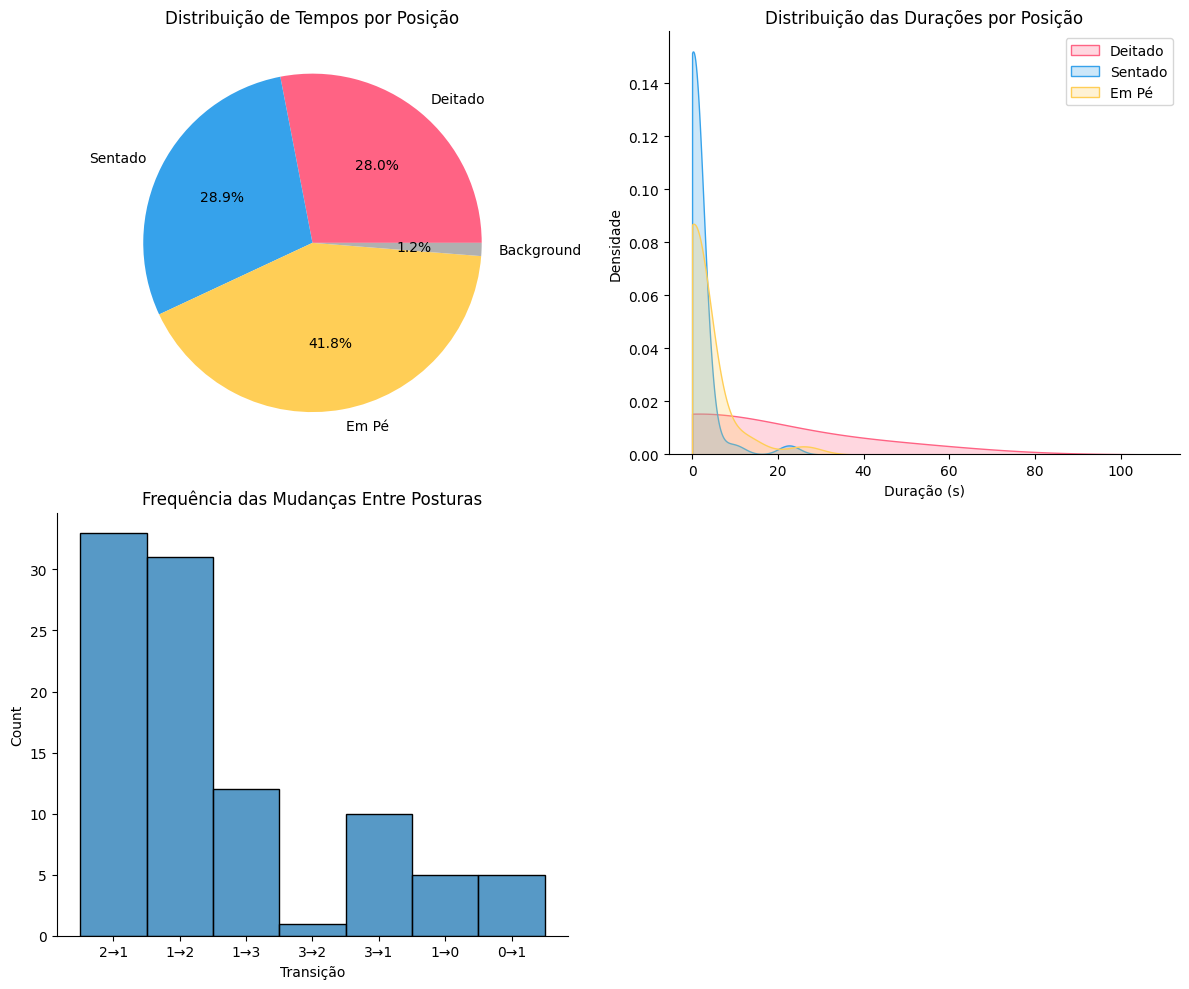

'/content/saida.mp4'

In [11]:
# Carrega o modelo YOLO previamente treinado usando o arquivo de pesos "best.pt"
modelo = YOLO('/content/best.pt')

# Aplica o modelo ao vídeo "teste.mp4" para detectar posturas
# O resultado será salvo e processado automaticamente pela função "processar_midia"
processar_midia('/content/teste_2.mp4', modelo, tipo='video')